# Next Month Credit Card Prediction

## Introduction

In the contemporary society, banks provide the most efficient access for human to managing their money. One of their products is credit card which allows users to spend money within a reasonable limit in advance and pay the money back later. It is hard to investigate all users background and use it to determine how much their maximum credit limit are. Thus, majority banks usually give users a relatively low limit and increase the amount of limit after they have enough information that support the users are trustworthy and have the ability to pay the money they spend in advance. One of the most important factors is whether the users paid their previous credit.  

In this blog, our goal is predicting whether a person will pay back in October 2005 based on some data from April to September 2005. The dataset is uploaded by UCI machine learning on Kaggle. This dataset contains 25 variables. Our target is represented as *default.payment.next.month* which is a binary feature: 1 means the user will not pay next month, 0 means the opposite.

Except for the prediction target just mentioned, the rest of the information can be used to predict. We have LIMIT_BAL for amount of given credit, SEX for gender, EDUCATION for education level, MARRIAGE for marital status, AGE for age, PAY_1 to PAY_6 for repayment status for different months, BILL_ATM1 to BILL_ATM6 for amount of bill statements for different months and PAY_AMT1 to PAY_AMT6 for amount of previous payment for different months.



## Importing useful tools

When we are doing machine by using a programming language, it is unrealistic that the programming language can achieve everything we want to do. Therefore, we need import other packages to achieve certain goals.

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

The very first thing we want to do is load the whole dataset to the platform we are working on

In [2]:
df_credit = pd.read_csv("UCI_Credit_Card.csv", encoding="utf-8",index_col=0)

## Exploratory Data Analysis(EDA)

We can visualize the exploratory variable to have a general sense about the dataset we are dealing with

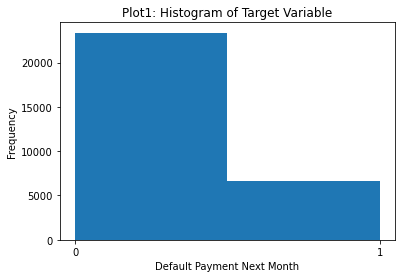

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [3]:
target = df_credit["default.payment.next.month"]
target.plot.hist(bins=2)
plt.xticks([0,1])
plt.xlabel("Default Payment Next Month")
plt.title("Plot1: Histogram of Target Variable")
plt.show()
df_credit["default.payment.next.month"].value_counts()

Based on the plot we just made, we can see there are much more 0-cases than 1-cases. Because normally, most people pay back their credit card bills. This kind of dataset is unbalanced.

In [4]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [5]:
df_credit.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Then, by using .info() and .describe() we will get a general idea of all the variables. For example, we can know if there is missing value for variables, the type of data for variables, the spread and center of variables. Knowing these will be beneficial for data preprocessing.

To train model and test the model trained, we will need to split the dataset to two sets. In train_test_split, we need the data, the test set proportion and set up random_state to make this code is reproducible. If we don't set up random_state, the function will generate different train set and test set every time we run the code. Setting up the random_state can make sure we get the exact same sets.

In [6]:
train_dfcredit, test_dfcredit = train_test_split(df_credit, test_size=0.3, random_state=123)

## Feature Engineering

Feature engineering is the process of transforming raw data into features that can be used in supervised learning.

In this case, we use the BILL_AMT and the PAY_AMT from April to September 2005 to generate an average amount (BILL_AMT_avg & PAY_AMT_avg) to represent each individual's BILL_AMT and PAY_AMT

In [7]:
#average of BILL_ATM
train_dfcredit = train_dfcredit.assign(
    BILL_AMT_avg = (train_dfcredit["BILL_AMT1"]+train_dfcredit["BILL_AMT2"]+train_dfcredit["BILL_AMT3"]+train_dfcredit["BILL_AMT4"]+train_dfcredit["BILL_AMT5"]+train_dfcredit["BILL_AMT6"])/6)
test_dfcredit = test_dfcredit.assign(
    BILL_AMT_avg = (test_dfcredit["BILL_AMT1"]+test_dfcredit["BILL_AMT2"]+test_dfcredit["BILL_AMT3"]+test_dfcredit["BILL_AMT4"]+test_dfcredit["BILL_AMT5"]+test_dfcredit["BILL_AMT6"])/6)
#average of PAY_ATM
train_dfcredit = train_dfcredit.assign(
    PAY_AMT_avg = (train_dfcredit["PAY_AMT1"]+train_dfcredit["PAY_AMT2"]+train_dfcredit["PAY_AMT3"]+train_dfcredit["PAY_AMT4"]+train_dfcredit["PAY_AMT5"]+train_dfcredit["PAY_AMT6"])/6)
test_dfcredit = test_dfcredit.assign(
    PAY_AMT_avg = (test_dfcredit["PAY_AMT1"]+test_dfcredit["PAY_AMT2"]+test_dfcredit["PAY_AMT3"]+test_dfcredit["PAY_AMT4"]+test_dfcredit["PAY_AMT5"]+test_dfcredit["PAY_AMT6"])/6)

## Data Preprocessing

To make the dataset more complete and efficient to perform data analysis. We need to do some preprocessing on the dataset.

In [8]:
target = "default.payment.next.month"
X_trainCRE = train_dfcredit.drop(columns=[target])
y_trainCRE = train_dfcredit[target]

By reading the description and the dataset, we can find that EDUCATION is ordinal and the levels includes 0, other, and two unknown. We can combine these four levels to one

In [9]:
X_trainCRE["EDUCATION"].replace(6, "others", inplace=True)
X_trainCRE["EDUCATION"].replace(5, "others", inplace=True)
X_trainCRE["EDUCATION"].replace(4, "others", inplace=True)
X_trainCRE["EDUCATION"].replace(3, "high school", inplace=True)
X_trainCRE["EDUCATION"].replace(2, "university", inplace=True)
X_trainCRE["EDUCATION"].replace(1, "graduate school", inplace=True)
X_trainCRE["EDUCATION"].replace(0, "others", inplace=True)
X_trainCRE["MARRIAGE"].replace(0, 3, inplace=True)

Assign all variables to different feature groups so they can be preprocessed based on their data type.

In [10]:
numerical= ["LIMIT_BAL","AGE", "PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6",  
            "BILL_AMT1","BILL_AMT3","BILL_AMT2","BILL_AMT4","BILL_AMT5","BILL_AMT6",
            "PAY_AMT1", "PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6",
           "BILL_AMT_avg", "PAY_AMT_avg"]
categorical = ["SEX", "MARRIAGE"]
ordinal = ["EDUCATION"]
# from low to high
education_levels = ["others", "high school", "university", "graduate school"]

combine all the transformers into one preprocessor which allows us process different strategies to different feature groups.

In [11]:
preprocessor = make_column_transformer(
    ("passthrough", numerical),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical),
    (OrdinalEncoder(categories=[education_levels], ), ordinal))

We only want to apply the preprocessor on X_trainCRE for now, because we want to keep testing data untouched until we start using it.

In [12]:
preprocessor.fit(X_trainCRE)

ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                 ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
                                  'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT4',
                                  'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                                  'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
                                  'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT_avg',
                                  'PAY_AMT_avg']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['SEX', 'MARRIAGE']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['others',
                                                             'high school',
     

After fit is done, everything we need are stored inside preporcessor. Now we list out the new_columns name.

In [13]:
new_columns = (numerical
               +preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist() 
               +ordinal)

use the preprocessor and the new columns names we just got to encode X_trainCRE. Now we get X_trainCRE_enc which is ready to be used to future analysis.

In [14]:
X_trainCRE_enc = pd.DataFrame(
    preprocessor.transform(X_trainCRE), index=X_trainCRE.index, columns=new_columns
)
X_trainCRE_enc

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT3,...,PAY_AMT5,PAY_AMT6,BILL_AMT_avg,PAY_AMT_avg,SEX_1,SEX_2,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION
ID,,,,,,,,,,,,,,,,,,,,,
16396,320000.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,29026.0,28695.0,...,0.0,7013.0,19868.833333,3505.166667,0.0,1.0,0.0,1.0,0.0,3.0
21449,440000.0,30.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,777.0,87426.0,...,15000.0,51663.0,88137.666667,47954.333333,0.0,1.0,0.0,1.0,0.0,3.0
20035,160000.0,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-18.0,-18.0,...,0.0,0.0,-18.000000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0
25756,120000.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,101596.0,104694.0,...,2005.0,1702.0,88447.000000,3356.000000,0.0,1.0,1.0,0.0,0.0,2.0
1439,50000.0,54.0,1.0,2.0,0.0,0.0,0.0,0.0,48153.0,27168.0,...,1000.0,1500.0,34180.166667,1100.000000,1.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28637,380000.0,37.0,0.0,0.0,0.0,0.0,0.0,2.0,13415.0,13277.0,...,0.0,3000.0,14478.166667,1441.000000,0.0,1.0,1.0,0.0,0.0,2.0
17731,360000.0,54.0,1.0,-2.0,-2.0,-1.0,0.0,-1.0,0.0,0.0,...,6941.0,0.0,2016.833333,1586.833333,0.0,1.0,1.0,0.0,0.0,3.0
28031,50000.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,47194.0,46777.0,...,327.0,329.0,33267.500000,1198.000000,0.0,1.0,1.0,0.0,0.0,1.0


## Baseline Model

Setting up a baseline model for future comparison.

In [15]:
scoring=["accuracy", "precision", "recall", "f1"]
dummy =DummyClassifier()
score = cross_validate(
    dummy, X_trainCRE_enc, y_trainCRE, return_train_score=True, scoring=scoring)
pd.DataFrame(score)

C:\Users\a3090\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a3090\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a3090\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a3090\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_cl

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.002992,0.005984,0.776905,0.776726,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002993,0.003989,0.776905,0.776726,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001995,0.004987,0.776667,0.776786,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001995,0.005016,0.776667,0.776786,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001995,0.003989,0.776667,0.776786,0.0,0.0,0.0,0.0,0.0,0.0


## Model fitting

After all the data is settled down, we can start fit them into models. Here, we are using LightGBM which is a modeling method based on decision tree. When the training finished, we can print the results and determine if it is trained well.

In [16]:
from lightgbm.sklearn import LGBMClassifier
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
scoring=["accuracy", "precision", "recall", "f1"]
results = cross_validate(pipe_lgbm, X_trainCRE, y_trainCRE, cv=5, return_train_score=True, scoring = scoring)
pd.DataFrame(results)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.104720,0.011968,0.811905,0.853393,0.635359,0.795142,0.368196,0.462543,0.466216,0.584864
1,0.105717,0.012966,0.818571,0.854821,0.663551,0.800091,0.378869,0.466276,0.482337,0.589186
2,0.098736,0.011968,0.823095,0.850714,0.693837,0.787766,0.372068,0.453333,0.484386,0.575491
3,0.113696,0.011968,0.826667,0.854226,0.698113,0.806695,0.394456,0.456267,0.504087,0.582865
4,0.097739,0.011968,0.816667,0.856726,0.668000,0.819002,0.356077,0.459733,0.464534,0.588898


Focusing on the f1 score, the test f1 score is around 0.466 to 0.504 and the train f1 score is approximately 0.588. The gap between these two f1 score is acceptable. Therefore, we can conclude that the f1 score is good for this modeling method.

## Hyperparameter optimization

Different models contains different hyperparameters. It is impossible to use the best hyperparameters in the first time training the model. To solve this problem, we can do hyperparameter optimization which will try different combinations of hyperparameters and score them. Then, we can find the best hyperparameters based on the highest score.

In [17]:
estimator = LGBMClassifier(random_state=123)
param_grid_lgbm = {
    "lgbmclassifier__learning_rate": [ 0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
    "lgbmclassifier__max_depth": [1, 5, 10, 20, 50, 80, 100]
}
random_search =RandomizedSearchCV(
    pipe_lgbm, param_grid_lgbm, cv=5, n_jobs=-1, n_iter = 10, return_train_score=True, scoring="f1"
)
random_search.fit(X_trainCRE, y_trainCRE)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('passthrough',
                                                                               'passthrough',
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
      

Print out the best parameters' value and the corresponding best score for future use.

In [18]:
print(random_search.best_params_)
print(random_search.best_score_)

{'lgbmclassifier__max_depth': 20, 'lgbmclassifier__learning_rate': 0.1}
0.48108140587536274


Now we have the best hyperparameters for these two. We need plug them into a new pipeline.

In [19]:
pipe_lgbm_best=make_pipeline(preprocessor, LGBMClassifier(random_state=123, max_depth = 80, learning_rate = 0.1))
pipe_lgbm_best.fit(X_trainCRE,y_trainCRE)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['LIMIT_BAL', 'AGE', 'PAY_0',
                                                   'PAY_2', 'PAY_3', 'PAY_4',
                                                   'PAY_5', 'PAY_6',
                                                   'BILL_AMT1', 'BILL_AMT3',
                                                   'BILL_AMT2', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6',
                                                   'BILL_AMT_avg',
                                                   'PAY_AMT_avg']),
                                                 ('onehotencoder

Now we want use our best model on our test set. But before that, we need do the same process as we did on our training set to our testing set. The reason why we don't do this when we are doing it to training set is that it will violate GOLDEN RULE. If GOLDEN RULE is violated, then our prediction will be not trustworthy. We should keep testing set unchanged until we are going to applying the model to it.

In [20]:
X_testCRE = test_dfcredit.drop(columns=[target])
y_testCRE = test_dfcredit[target]

X_testCRE["EDUCATION"].replace(6, "others", inplace=True)
X_testCRE["EDUCATION"].replace(5, "others", inplace=True)
X_testCRE["EDUCATION"].replace(4, "others", inplace=True)
X_testCRE["EDUCATION"].replace(3, "high school", inplace=True)
X_testCRE["EDUCATION"].replace(2, "university", inplace=True)
X_testCRE["EDUCATION"].replace(1, "graduate school", inplace=True)
X_testCRE["EDUCATION"].replace(0, "others", inplace=True)
X_testCRE["MARRIAGE"].replace(0, 3, inplace=True)

Loading the corresponding metrics and print the scores out.

In [21]:
from sklearn.metrics import ( f1_score)
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# carry out prediction
print(f1_score(y_testCRE, pipe_lgbm_best.predict(X_testCRE)))
print(recall_score(y_testCRE, pipe_lgbm_best.predict(X_testCRE)))
print(precision_score(y_testCRE, pipe_lgbm_best.predict(X_testCRE)))

0.47831715210355985
0.37936344969199176
0.6471103327495622


## Feature Importance

If we want to know the extent to which different features have an impact on the target. We can do this.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


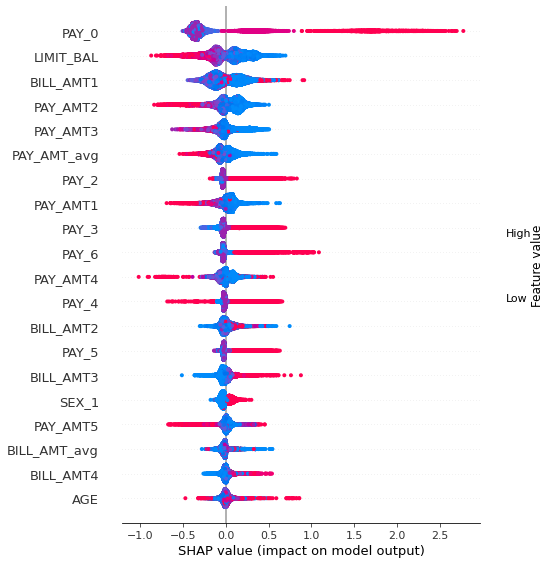

In [22]:
import shap
lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_trainCRE_enc)
shap.summary_plot(train_lgbm_shap_values[1], X_trainCRE_enc)

Except the plot, we can also use a table to achieve the similar goal.

In [23]:
values = np.abs(train_lgbm_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=new_columns, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
PAY_0,0.489916
LIMIT_BAL,0.183101
BILL_AMT1,0.142342
PAY_AMT2,0.128219
PAY_AMT3,0.104244
PAY_AMT_avg,0.088025
PAY_2,0.080290
PAY_AMT1,0.077733
PAY_3,0.075895
PAY_6,0.066515


According to the plots and the table above, we can find PAY_0 has the most positive SHAP Feature value means that PAY_0 affect the target the most on a positive direction.

## Explaining predictions

Moreover, expect we can find what features affect our target the most in general, we can also explain what features and how they affect each individual predictions. Here are two examples.

We can split the y_testCRE to 2 sets based on the target value. We randomly choose the 30th item in each set.

In [24]:
y_testCRE_reset = y_testCRE.reset_index(drop=True)

default_yes = y_testCRE_reset[y_testCRE_reset == 1].index.tolist()
default_no = y_testCRE_reset[y_testCRE_reset == 0].index.tolist()

yes_exp = default_yes[30]
no_exp = default_no[30]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


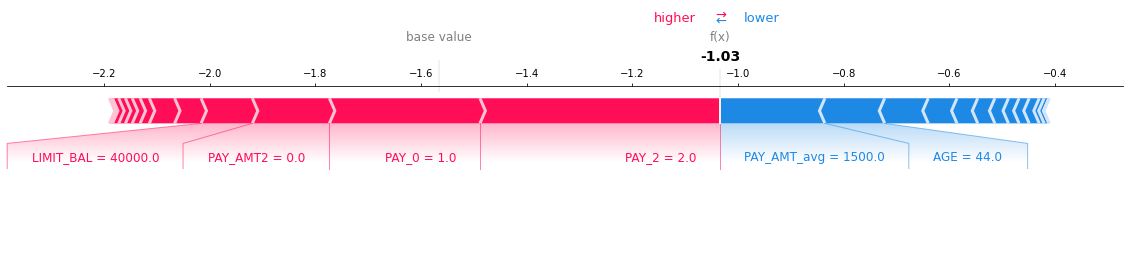

In [25]:
shap_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
X_testCRE_enc = pd.DataFrame(
    preprocessor.transform(X_testCRE), index=X_testCRE.index, columns=new_columns
)
test_lgbm_shap_values = shap_explainer.shap_values(X_testCRE_enc)
shap.force_plot(
    shap_explainer.expected_value[1],
    train_lgbm_shap_values[1][yes_exp, :],
    X_testCRE_enc.iloc[yes_exp, :],
    matplotlib=True,
)

for the 30th YES item, PAY_2 pushes the result to the right side the most, then PAY_0. For the negative side, PAY_AMT_avg did the most, and then AGE. After all features did their contribute, the final result is located at -1.03 which is larger than the base value. Therefore, our final result is YES

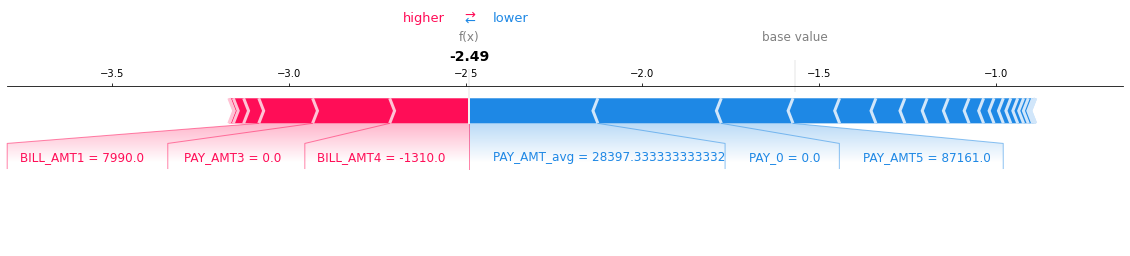

In [26]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][no_exp, :],
    X_testCRE_enc.iloc[no_exp, :],
    matplotlib=True,
)

Similarly, for the 30th No item, BILL_AMT4 pushes the result to the right side the most, then PAY_AMT3. For the negative side, PAY_AMT_avg did the most, and then PAY_0. After all features did their contribute, the final result is located at -2.49 which is less than the base value. Therefore, our final result is No

## Conclusion

The model we fitted offered good f1 scores. The gap between train and test set is small which indicates this model can work well in the real world. We can see PAY_0 is the most effective term through our feature importance plot. What we did on feature engineering part doesn't meet our expectations. We expect the mean value of BILL_AMT and PAY_AMT should be representative in terms of these two groups. Conversely， their feature importance coefficients are not relatively large. The dataset is significantly unbalanced, which tends to bias our focus towards precision parts. There are also limitations on this research based on this dataset. For instance, we haven't considered about interactions between variables, the data may not covered all the factors which could possibly affect the target value.